# Multi-height wind data

In this example we explore the calculation of multi-height wind data, as for example obtained from WRF results or downloaded from the [NEWA website](https://map.neweuropeanwindatlas.eu/) at a single point.

Here we will use the static data file `WRF-Timeseries-4464.csv.gz` that is part of the `foxes` static data. It has the following data structure:

```
Time,WS-50,WS-75,...,WS-500,WD-50,WD-75,...,WD-500,TKE-50,TKE-75,...,TKE-500,RHO
2009-01-01 00:00:00,7.37214,7.42685,...,1.28838
...
2009-01-31 23:50:00,10.27767,10.36368,...,1.30095
```

The time stamp column marks one month in 10 minute steps, and the wind speed (WS), wind direction (WD) and turbulent kinetic energy (TKE) are provided at 8 heights between 50 and 500 m. The air density (RHO) does not have height dependency but varies with time.

The basic assumption of this example is that we can calculate our wind farm results based on this data, i.e., that the horizontal variation can be neglected (for completely heterogeneous inflow data, see the corresponding example).

These are the imports for this example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV
import foxes.constants as FC

First, we setup the model book and the wind farm. We choose 5 turbines in a row:

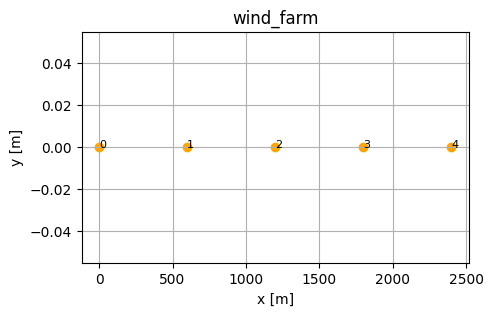

In [2]:
# Create model book:
mbook = foxes.ModelBook()

# create wind farm, a single row of turbines:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=[0.0, 0.0],
    xy_step=[600.0, 0.0],
    n_turbines=5,
    turbine_models=["NREL5MW"],
    H=200.,
    verbosity=0,
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(5,3))
plt.show()

Note that we manually change the hub height from 90 m to 200 m here. Next, we create the states based on the static data file `WRF-Timeseries-4464.csv.gz`:

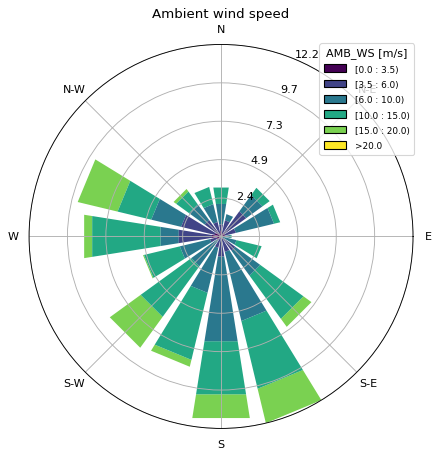

In [3]:
states = foxes.input.states.MultiHeightTimeseries(
    data_source="WRF-Timeseries-4464.csv.gz",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={},
    heights=[50, 75, 90, 100, 150, 200, 250, 500],
    fixed_vars={FV.TI: 0.05},
)

o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

Our file has already the default column names as expected by `foxes`. However, otherwise you can use the `var2col` option as a mapping from the expected to the actual column names, if needed. Note that the `heights` are searched for all output variables that are neither mentioned in `fixed_vars` not appear as height independent column names (e.g. `RHO` instead of `RHO-50`, etc.).

Let's next setup our algorithm:

In [4]:
algo = foxes.algorithms.Downwind(
    mbook,
    farm,
    states=states,
    rotor_model="grid9",
    wake_models=["Bastankhah2014_linear_k002"],
    wake_frame="rotor_wd",
    partial_wakes_model="auto",
    chunks={FC.STATE: 1000},
    verbosity=0,
)

Our next goal is the visualization of the vertical wind profile. For that we select a certain time step where the wind direction is approximately from the west. We can do this by initializing the states using the `states_loc` option:

In [5]:
states.reset(states_loc=["2009-01-06 13:50:00"])

We now calculate this single state and create the vertical flow figure:

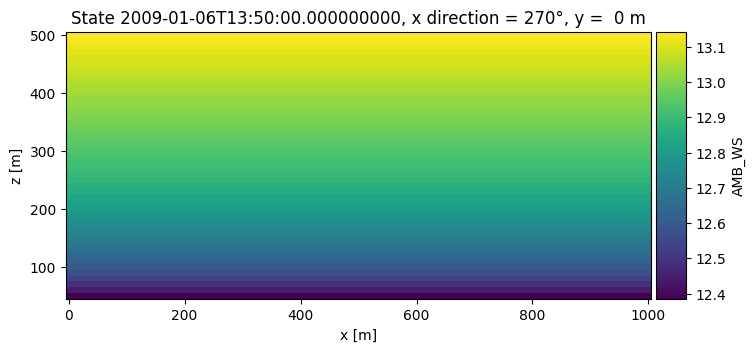

In [6]:
farm_results = algo.calc_farm()

o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xz(FV.AMB_WS, resolution=10, x_direction=270,
        xmin=0., xmax=1000., zmin=50., zmax=500., figsize=(8,6))
fig = next(g)
plt.show()

For the full calculation of all 4464 states, we now undo our earlier states selection:

In [7]:
states.reset(states_loc=None)

We can now calculate the full states results:

                                    WD       REWS            P
state               turbine                                   
2009-01-01 00:00:00 0        340.14377   7.593022  1533.584614
                    1        340.14377   7.593022  1533.584614
                    2        340.14377   7.593022  1533.584614
                    3        340.14377   7.593022  1533.584614
                    4        340.14377   7.593022  1533.584614
...                                ...        ...          ...
2009-01-31 23:50:00 0         86.83636   6.660154  1034.432767
                    1         86.83636   6.738764  1069.775436
                    2         86.83636   6.880119  1133.327951
                    3         86.83636   7.344888  1388.612517
                    4         86.83636  10.532676  4041.896723

[22320 rows x 3 columns]


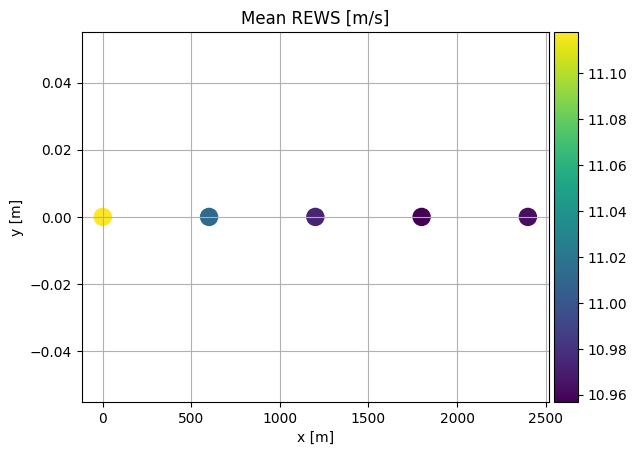


Farm power        : 15.0 MW
Farm ambient power: 15.3 MW
Farm efficiency   : 97.91 %
Annual farm yield : 131.38 GWh


In [8]:
farm_results = algo.calc_farm()

fr = farm_results.to_dataframe()
print(fr[[FV.WD, FV.REWS, FV.P]])

o = foxes.output.FarmLayoutOutput(farm, farm_results)
o.get_figure(color_by="mean_REWS", title="Mean REWS [m/s]", s=150, annotate=0)
plt.show()

o = foxes.output.FarmResultsEval(farm_results)
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nFarm power        : {P/1000:.1f} MW")
print(f"Farm ambient power: {P0/1000:.1f} MW")
print(f"Farm efficiency   : {o.calc_farm_efficiency()*100:.2f} %")
print(f"Annual farm yield : {o.calc_farm_yield(algo=algo):.2f} GWh")